In [31]:
import os
import json
import copy
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [1]:
import sys
sys.dont_write_bytecode = True
sys.path.append('../datatools')
from maneger import DataManager
from preproc import Preprocessor
# from utterance.feature import Feature
from feature import Feature

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


ImportError: cannot import name 'preproc'

In [33]:
path = '../error_category_classification/dbdc5_ja_dev_labeled/'
datalist = ['DCM', 'DIT', 'IRS']
# datalist = ['DCM']
    # List of error types
error_types = ['Unclear intention', 'Wrong information',
    'Ignore question', 'Topic transition error', 
    'Lack of information', 'Repetition', 
    'Contradiction', 'Self-contradiction',
    'Lack of common sense', 'Semantic error',
    'Grammatical error', 'Ignore proposal', 
    'Ignore offer', 'Lack of sociality', 
    'Uninterpretable', 'Ignore greeting', 
    'No-Err']

pre = Preprocessor()
df = pre.read_json_with_NoErr(path, datalist)

300


In [34]:
F_path = "../X_y_data/response/"
F_name = "typeClassify_F.dill"
featureM = DataManager(F_path, format_="dill")

F = featureM.load_data(F_name)
F.set_preprocessor(pre)

success load : ../X_y_data/response/typeClassify_F.dill


In [35]:
model_path = "../models/response/"
model_name = "typeClassify_M.pickle"
modelM = DataManager(model_path)

lr = modelM.load_data(model_name)

success load : ../models/response/typeClassify_M.pickle


In [36]:
label_list = "YN WH please proposal plain".split()
label_dict = dict( zip(label_list, range(len(label_list))) )
label_dict2 = dict( zip(range(len(label_list)), label_list) )

In [37]:
def extract_no_error_particular(df, mode):
    prev_u = ""
    utterances = []
    for d, u, s, e in zip(df.did, df.usr, df.sys, df.ec):
        # print(type(u))
        f = F.featurization(s)
        y = lr.predict(f.reshape(1,-1))
        if mode=="question":
            if y == 0 or y == 1:
                # print("y: {0}, s: {1}, \n u: {2}\n".format(label_dict2[int(y)], s, prev_u))
                utterances.append([s, prev_u])
        elif mode=="please":
            if y == 2:
                utterances.append([s, prev_u])
        elif mode=="proposal":
            if y == 3:
                utterances.append([s, prev_u])
        prev_u = u
    return utterances


In [38]:
def extract_error(df, errors):
    utterances = []
    for d, u, s, e in zip(df.did, df.usr, df.sys, df.ec):
        for err in errors:
            if err in e:
                utterances.append([u, s])
    return utterances

In [53]:
errors = ["Ignore proposal"]
mode = "please"

[['海に行かないんですね？', ''],
 ['外でとります', 'そうらしいですね。いつもスイカの種を噛んで食べていますか？'],
 ['外食は二人で行きますねぇ', '栄養面を考えて食事をとることは大切ですよね。'],
 ['海に行かないんですね？', '手洗いは基本だよ。'],
 ['家族で買い物に行きます？？', '週末、行く予定だよ。'],
 ['家族で食事に行きますか？', '家族と行く予定です。'],
 ['家族でどこかに出かけます？？', '買物はたいてい家族と一緒だね。'],
 ['家族で食べに行きますか？', 'たまに家族で外食に行くよ。'],
 ['家族で初詣に行くんですか？', 'おばあちゃんちに行くつもりです。'],
 ['家族で初詣に行ってるんですね。家族で旅行に行ってるのですか？', '食べに行ったり、温泉行ったりします。'],
 ['退屈を嫌いますか？', 'そうだね。子供を持って初めて、家族の大切さが分かった気がします。'],
 ['お名前はco.jpに添えます', 'そうですね、海外旅行に行った時なんかは危険が多いのでいろいろ考えながらケースバイケースに対応しますね。'],
 ['旅行に参加しちゃった', '私はアトムといいます'],
 ['旅行を振り返りますか', 'どこにいったの？'],
 ['しりとりでもしましょうか', '奇遇ですね、私も退屈してたとこです。'],
 ['しりとりを楽しみましょうね', 'じゃあ、果物しりとりしましょう。'],
 ['紅玉を求めるかもしれない', 'あなたの負けでいいですか？'],
 ['そういえば、この間、旅行したと伺いましたが、奇遇に驚きます', '何をもらったら喜ぶ？'],
 ['お天気の良さはどうですか？', 'こんにちは'],
 ['そういえば、あなたは美味しいものを食べるのが好きでしたよね？スイカは大好きですね', 'スイカは大好きだよ。'],
 ['ももを探します', 'ぶどうはきらいですか？'],
 ['熱中症に気をつけないんですか？', 'だよね〜'],
 ['エゾシカを見ます', 'うん。けっこう会えるよ。'],
 ['熱中症に気をつけか？？', '子供は好きですか？'],
 ['爆音で流します', '沢田研二は好きですか'],
 ['爆音が流れます', 'よく聞く音楽

In [40]:
igque = extract_error(df, errors)

In [41]:
igque_no = extract_no_error_particular(df, mode=mode)

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

torch.cuda.is_available()

True

In [43]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size, batch_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True, bidirectional=True )
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        # self.softmax = 
    
    def forward(self, x):
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        batch_size, seq_len = x.shape[0], x.shape[1]
        _, hidden_layer = self.lstm(x)
        # print(hidden_layer)
        bilstm_out = torch.cat([hidden_layer[0][0], hidden_layer[0][1]], dim=1)
        # y = self.hidden2tag(hidden_layer[0].view(batch_size, -1))

        y = self.hidden2tag(bilstm_out)
        y = F.log_softmax(y, dim=1)
        return y

In [44]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [45]:
from pyknp import Juman
from sentence_transformers import SentenceTransformer
import scipy.spatial
model_path = "/home/yamada/Downloads/training_bert_japanese"
Nmodel = SentenceTransformer(model_path, show_progress_bar=False)
emb_dim = Nmodel.encode(["お辞儀をしている男性会社員"])[0].shape[0]

In [46]:
def make_X(convs):
    X_data = []
    
    for conv in convs :
        sentence_vectors = Nmodel.encode(conv)
        X_data.append(sentence_vectors)
    return np.array(X_data)

In [47]:
data_path = "../X_y_data/response/"
data_name = "{0}1.pickle".format(mode)
dataM = DataManager(data_path)
print(data_name)

proposal1.pickle


In [48]:
if dataM.is_exist(data_name):
    
    DATA_Xy = dataM.load_data(data_name)
    X = DATA_Xy[0]
    y = DATA_Xy[1]
else:
    # X_data, y_data = pre.extract_X_y(df, error_types, seq_len)
    X = make_X(igque + igque_no)
    y = np.concatenate( [ np.ones(len(igque)), np.zeros(len(igque_no)) ] )
    dataM.save_data(data_name, [X, y])

success save : ../X_y_data/response/proposal1.pickle


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [51]:
leng = len(y_train)
print(leng)
for i, v in enumerate(y_train):
    if leng %(i+1) == 0:
        print(i+1, end=", ")

62
1, 2, 31, 62, 

In [21]:
BATCH_SIZE = 81
epoch_ = 600
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [22]:
EMBEDDING_DIM = emb_dim
HIDDEN_DIM = emb_dim*4
OUTPUT_DIM = 2
# seq_len = length

In [23]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [24]:
losses = []
loss_border = 0.0001
# print("error[{0}]".format(error_types[error_i]))
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        X_t_tensor = torch.tensor(data[0], device='cuda:0').float()
        # y_t_tensor = torch.tensor(data[1].reshape(batch_size, 1), device='cuda:0').float()
        y_t_tensor = torch.tensor(data[1], device='cuda:0').long()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)

        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


epoch 50 	 loss 0.00019598204744397663
epoch 100 	 loss 6.844669951533433e-05
epoch 150 	 loss 3.473496917649754e-05
epoch 200 	 loss 2.006154136324767e-05
epoch 250 	 loss 1.3079136238047795e-05
epoch 300 	 loss 9.018269224725373e-06
epoch 350 	 loss 6.440148411002156e-06
epoch 400 	 loss 4.748263336296077e-06
epoch 450 	 loss 3.605651585303349e-06
epoch 500 	 loss 2.7720707862499694e-06
epoch 550 	 loss 2.122307236618326e-06
epoch 600 	 loss 1.6839117193967468e-06
done


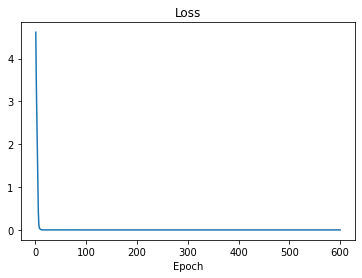

In [25]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [26]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[56 16]
 [13 49]]
accuracy =  0.7835820895522388
precision =  0.7538461538461538
recall =  0.7903225806451613
f1 score =  0.7716535433070866


In [28]:
model_path = "../models/response/"
model_name = "{0}1_M.pickle".format(mode)
modelM = DataManager(model_path)
print(model_name)

question1_M.pickle


In [29]:
modelM.save_data(model_name, model)

success save : ../models/response/question1_M.pickle
